In [1]:
using DrWatson
@quickactivate 

using Flux, Graphs, Statistics, Plots, GraphPlot, Zygote
using Cairo, Compose
using SumProductSet
import Distributions
import Mill

# Graph clustering on Karate graph data

In [2]:
g = smallgraph(:karate)
vs = collect(vertices(g))
x = Flux.onehotbatch(vs, vs)
ds_train = Mill.BagNode(x, g.fadjlist)

BagNode 	# 34 obs, 2.875 KiB
  └── ArrayNode(34×34 OneHotArray with Bool elements) 	# 34 obs, 192 bytes

In [3]:
dir_rand = d->rand(Distributions.Dirichlet(d, 2*d))
f_cat = d->_Categorical(log.(dir_rand(d)))
m = reflectinmodel(ds_train[1], 2; f_card=()->_Poisson(log(4)), f_cat=f_cat)
m

SumNode
  ├── SetNode
  │     ├── c: _Poisson
  │     └── f: _Categorical
  └── SetNode
        ├── c: _Poisson
        └── f: _Categorical


In [4]:
function train!(m, x; niter::Int=1000, opt=ADAM(1.))
    ps = Flux.params(m)

    for i in 1:niter
        gs = gradient(() -> SumProductSet.ul_loss(m, x), ps)
        Flux.Optimise.update!(opt, ps, gs)
    end
end

train! (generic function with 1 method)

In [5]:
colors = [colorant"yellow", colorant"red"]
nodelabel = 1:nv(g)
layout=_->spring_layout(g, 3)

#10 (generic function with 1 method)

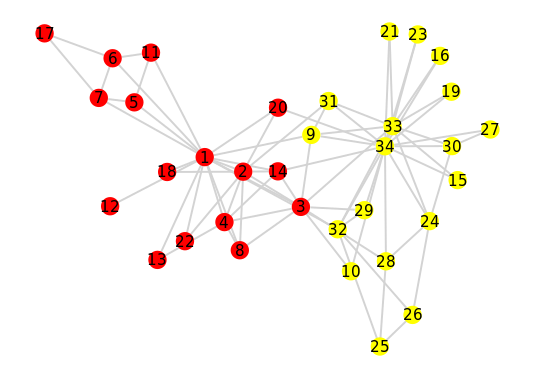

In [6]:
train!(m, ds_train; opt=ADAM(1.), niter=200)
predict = x->mapslices(argmax, logjnt(m, x), dims=1)[:] 
clusters = predict(ds_train);
gplot(g, nodefillc=colors[clusters], layout=layout, nodelabel=nodelabel)

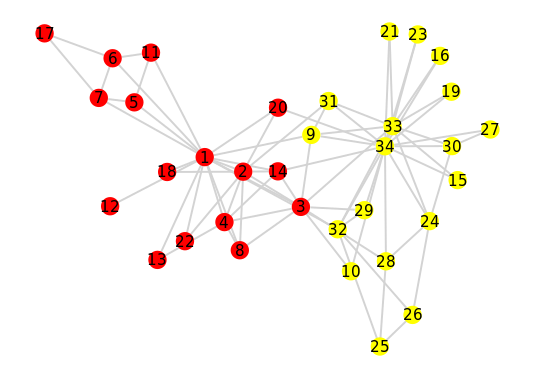

In [7]:
m = reflectinmodel(ds_train[1], 2; f_card=()->_Poisson(log(3)), f_cat=f_cat)
train!(m, ds_train; opt=ADAM(0.1), niter=200)
clusters = predict(ds_train)
gplot(g, nodefillc=colors[clusters], layout=layout, nodelabel=nodelabel)

In [8]:
# draw(PDF("karate_presentation_clustered.pdf", 16cm, 9cm), gplot(g,nodefillc=colors[clusters], layout=layout, nodelabel=nodelabel))